# Python之ML--聚类分析

使用监督学习来构建学习模型,其中训练数据都是事先已知预测结果的,即训练数据中已提供了数据的类标;在本节,我们将转而研究聚类分析,它是一个无监督学习(unsupervised learning),可以在事先不知道正确结果(即无类标信息或预期输出值)的情况下,发现数据本身所蕴含的结构等信息;聚类的目标是发现数据中自然形成的分组,使得每个簇内样本的相似性大于与其他簇内样本的相似性

主要知识点如下：
- 使用k-means算法发现簇中心
- 使用自底向上的方法构建层次聚类树
- 基于密度聚类方法发现任意形状簇

## 一.使用k-means算法对相似性进行分组

k-means算法是基于原型的聚类.两种聚类：层次(hierarchical)聚类和基于密度(density-based)的聚类.基于原型的聚类意味着每个簇都对应一个原型,它可以是一些具有连续型特征的相似点的中心点(centroid)(平均值),或者是类别特征情况下相似点的众数(medoid)--最典型或是出现频率最高的点.虽然k-means算法可以高效识别球形簇,但是此算法的缺点在于必须事先指定先验的簇数量k.如果k值选择不当,则可能导致聚类效果不佳

尽管k-means聚类适用于高维数据,但出于可视化需要,我们将使用一个二维数据集的例子进行演示：

In [69]:
from IPython.display import Image

In [72]:
from sklearn.datasets import make_blobs

X,y=make_blobs(n_samples=150,
              n_features=2,
              centers=3,
              cluster_std=0.5,
              shuffle=True,
              random_state=0)

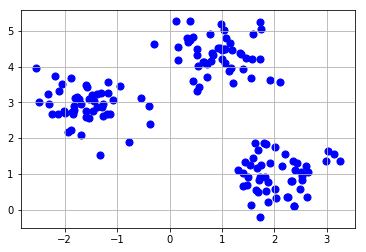

In [73]:
import matplotlib.pyplot as plt

plt.scatter(X[:,0],X[:,1],c='blue',marker='o',s=50)

plt.grid()
plt.show()

我们刚才创建的数据集中包含150个随机生成的点,它们大致分为三个高密度区域,其二维散点图如下：

在聚类算法的实际使用应用,我们没有任何关于这些样本的类别基础信息;否则算法就要划分到监督学习的范畴.由此,我们的目标就是根据样本自身特征的相似性对其进行分组,对此可采用k-means算法,具体有如下四个步骤：
1. 从样本点中随机选择k个点作为初始簇中心
2. 将每个样本点划分到距离它最近的中心点u^(j),j属于{1,...,k}所代表的簇中
3. 用各簇中所有样本的中心点替代原有的中心点
4. 重复步骤2和3,直到中心点不变或者达到预定迭代次数时,算法终止

我们可以将相似性定义为距离的倒数,在m维空间中,对于特征取值为连续型实数的聚类分析来说,常用的距离度量标准是欧几里得距离的平方：
d(x,y)^{2}=\sum_{j=1}^{m}({x_j}-{y_j}){^2}=||x-y||_{2}^{2}

公式中,小标索引j为样本点x和y的第j个维度(特征列).使用上标i和j代表样本索引和簇索引

基于欧几里得度量标准,我们可以将k-means算法描述为一个简单的优化问题,通过迭代使用簇内误差平方和(within-cluster sum of squared errors,SSE)最小,也称作簇惯性(cluster intertia)

SSE=\sum_{i=1}^{n}\sum_{j=1}^{k}w^{(i,j)}=||x^{(i)-\mu ^{(j)}}||_{2}^{2}

其中,u^(j)为簇j的中心点,如果样本x^(i)属于簇j,则有w^(i,j)=1,否则w^(i,j)=0

使用scikit-learn中的KMeans类将k-means算法应用于我们的示例数据集：

In [74]:
from sklearn.cluster import KMeans

km=KMeans(n_clusters=3,
         init='random',
         n_init=10,
         max_iter=300,
         tol=1e-04,
         random_state=0)

y_km=km.fit_predict(X)

我们设定簇数量为3个;指定先验的簇数量是k-means算法的一个缺陷,设置n_init=10,程序能够基于不同的随机初始中心点独立运行算法10次,并从中选择SSE最小的作为最终模型;通过max_iter参数,指定算法每轮运行的迭代次数.请注意,在scikit-learn对k-means算法的实现中,如果模型收敛了,即使未达到预定迭代次数,算法也将终止

解决收敛问题的一个方法就是为tol参数设置一个较大的值,此参数控制对簇内误差平方和的容忍度,此容忍度用于判定算法是否收敛

### 1.k-means++

我们已经讨论了经典的k-means算法,它使用随机点作为初始中心点,若初始中心点选择不当,有可能会导致簇效果不佳或产生收敛速度慢等问题.解决此问题的一种方案就是在数据集上多次运行k-means算法,并根据误差平方和(SSE)选择性最好的模型.另一种方案就是使用k-means++算法让初始中心点彼此尽可能远离,相比传统k-means算法,它能够产生更好,更一致的结果

k-means++算法的初始化过程可以概括如下：
1. 初始化一个空的集合M,用于存储选定的k个中心点
2. 从输入样本中随机选定第一个中心点u^(j),并将其加入到集合M中
3. 对于集合M之外的任一样本点x^(i),通过计算找到与其平方距离最小的样本d(x^(i),M)^2
4. 使用加权概率分布-----来随机选择下一个中心点u^(p)
5. 重复步骤2,3,直到选定k个中心点
6. 基于选定的中心点执行k-means算法

通过scikit-learn的KMeans对象来实现k-means++算法,只需将init参数的值random替换为k-means++(默认值)即可

我们已经将簇结果存储在y_km中,并且讨论k-means算法面临的挑战.现在对k-means算法的簇结果及其相应的簇中心做可视化展示.簇中心保存在KMeans对象的centers_属性中：

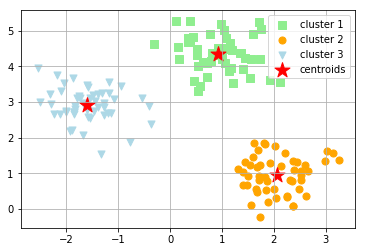

In [75]:
plt.scatter(X[y_km==0,0],X[y_km==0,1],
           s=50,c='lightgreen',marker='s',label='cluster 1')

plt.scatter(X[y_km==1,0],X[y_km==1,1],
           s=50,c='orange',marker='o',label='cluster 2')

plt.scatter(X[y_km==2,0],X[y_km==2,1],
           s=50,c='lightblue',marker='v',label='cluster 3')

plt.scatter(km.cluster_centers_[:,0],km.cluster_centers_[:,1],
           s=250,c='red',marker='*',label='centroids')

plt.legend()
plt.grid()
plt.show()

在上面的散点图中,我们可以看到,通过k-means算法得到的3个中心点位于各球状簇的圆心位置

k-means的缺点之一就是我们必须指定一个先验的簇数量k,但在实际应用中,簇数量并非总是显而易见的,特别当我们面对的是一个无法可视化展现的高维数据集.k-means的另一个特点就是簇不可重叠,也不可分层,并且假定每个簇至少会有一个样本

### 2.硬聚类与软聚类

硬聚类(hard clustering)指的是数据集中每个样本只能划至一个簇的算法

软聚类(soft clustering)指的是一个样本划分到一个或者多个簇

### 3.使用肘方法确定簇的最佳数量

无监督学习中存在一个问题,就是我们并不知道问题的确切答案.由于没有数据集样本类标的确切数据,我们无法在无监督学习中使用评估监督学习模型性能的相关技术.因此,为了对聚类效果进行定量分析,我们需要使用模型内部的固有度量来比较不同k-means聚类结果的性能.在完成KMeans模型的拟合后,簇内误差平方和可以通过inertia属性来访问

In [76]:
print('Distortion:%.2f'%km.inertia_)

Distortion:72.48


基于簇内误差平方和,我们可使用图形工具,即所谓的肘方法,针对给定任务估计出最优的簇数量k.直观地看,增加k的值可以降低聚类偏差.肘方法的基本理念就是找出聚类偏差聚增时的k值.我们可以绘制出不同k值对应的聚类偏差图

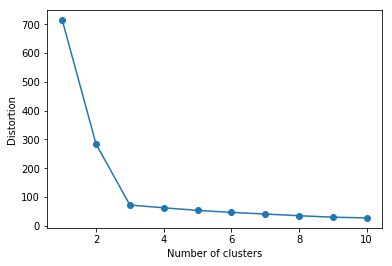

In [77]:
distortions=[]

for i in range(1,11):
    km=KMeans(n_clusters=i,
             init='k-means++',
             n_init=10,
             max_iter=300,
             random_state=0)
    km.fit(X)
    distortions.append(km.inertia_)
    
plt.plot(range(1,11),distortions,marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Distortion')

plt.show()

如图所示,当k=3时图案呈现了肘型,这表明对于次数据集来说,k=3的确是一个好的选择

### 4.通过轮廓图定量分析聚类质量

另一种评估聚类质量的定量分析方法是轮廓分析(silhouette analysis).此方法也可用于k-means之外的其他聚类方法.轮廓分析可以使用一个图形工具来度量簇中样本聚集的密集程度.轮廓系数的值介于-1到1之间

轮廓系数可通过scikit-learn中metric模块下的silhouette_samples计算得到,也可以选择用silhouette_scores.后者计算所有样本点的轮廓系数均值

绘制k=3时k-means算法的轮廓系数图：

In [78]:
km=KMeans(n_clusters=3,
         init='k-means++',
         n_init=10,
         max_iter=300,
         tol=1e-04,
         random_state=0)

y_km=km.fit_predict(X)

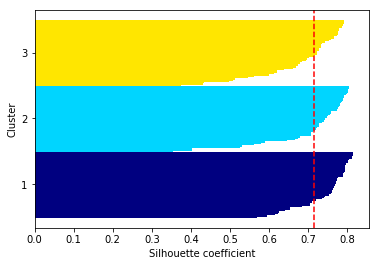

In [79]:
import numpy as np
from matplotlib import cm
from sklearn.metrics import silhouette_samples

cluster_labels=np.unique(y_km)
n_clusters=cluster_labels.shape[0]
silhouette_vals=silhouette_samples(X,y_km,metric='euclidean')

y_ax_lower,y_ax_upper=0,0

yticks=[]

for i,c in enumerate(cluster_labels):
    c_silhouette_vals=silhouette_vals[y_km==c]
    c_silhouette_vals.sort()
    
    y_ax_upper+=len(c_silhouette_vals)
    color=cm.jet(i/n_clusters)
    
    plt.barh(range(y_ax_lower,y_ax_upper),
            c_silhouette_vals,
            height=1.0,
            edgecolor='none',
            color=color)
    yticks.append((y_ax_lower+y_ax_upper)/2)
    y_ax_lower+=len(c_silhouette_vals)
    
silhouette_avg=np.mean(silhouette_vals)

plt.axvline(silhouette_avg,color='red',linestyle='--')

plt.yticks(yticks,cluster_labels+1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.show()

通过观察轮廓图,我们可以快速知晓不同簇的大小,而且能够判断簇中是否包含异常点.为了评判聚类效果的优劣,我们在图中增加了轮廓系数的平均值(虚线)

为了解聚类效果不佳的轮廓图的形状,我们使用两个中心点来初始化k-means算法

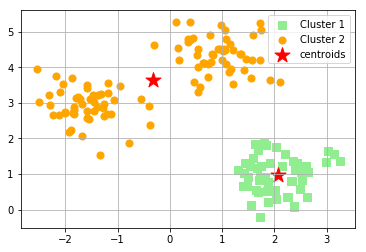

In [80]:
km=KMeans(n_clusters=2,
         init='k-means++',
         n_init=10,
         max_iter=300,
         tol=1e-04,
         random_state=0)

y_km=km.fit_predict(X)

plt.scatter(X[y_km==0,0],
           X[y_km==0,1],
           s=50,c='lightgreen',
           marker='s',
           label='Cluster 1')

plt.scatter(X[y_km==1,0],
           X[y_km==1,1],
           s=50,c='orange',
           marker='o',
           label='Cluster 2')

plt.scatter(km.cluster_centers_[:,0],
           km.cluster_centers_[:,1],
           s=250,marker='*',c='red',
           label='centroids')

plt.legend()

plt.grid()
plt.show()

样本点形成了三个球状分组,其中一个中心点落在了两个球状分组的中间

接下来,我们绘制轮廓图对聚类结果进行评估.请记住,在实际应用中,我们常常处理的是高维数据,因此并不奢望使用二维散点图对数据集进行可视化

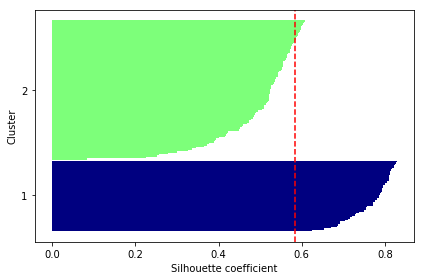

In [82]:
cluster_labels = np.unique(y_km)
n_clusters = cluster_labels.shape[0]
silhouette_vals = silhouette_samples(X, y_km, metric='euclidean')
y_ax_lower, y_ax_upper = 0, 0
yticks = []
for i, c in enumerate(cluster_labels):
    c_silhouette_vals = silhouette_vals[y_km == c]
    c_silhouette_vals.sort()
    y_ax_upper += len(c_silhouette_vals)
    color = cm.jet(float(i) / n_clusters)
    plt.barh(range(y_ax_lower, y_ax_upper), c_silhouette_vals, height=1.0, 
             edgecolor='none', color=color)

    yticks.append((y_ax_lower + y_ax_upper) / 2.)
    y_ax_lower += len(c_silhouette_vals)
    
silhouette_avg = np.mean(silhouette_vals)
plt.axvline(silhouette_avg, color="red", linestyle="--") 

plt.yticks(yticks, cluster_labels + 1)
plt.ylabel('Cluster')
plt.xlabel('Silhouette coefficient')

plt.tight_layout()
# plt.savefig('./figures/silhouette_bad.png', dpi=300)
plt.show()

由图可见,轮廓具有明显不同的长度和宽度,这进一步证明该聚类并非最优结果

## 二.层次聚类

我们将学习另一种基于原型的聚类：层次聚类(hierarchical clustering).层次聚类算法的一个优势在于：它能够使我们绘制出树状图(dendrogram,基于二叉层次聚类的可视化),这有助于我们使用有意义的分类法解释聚类结果.层次聚类的另一优势在于我们无需事先指定簇数量

层次聚类有两种主要方法：凝聚(agglomerative)层次聚类和分裂(divisive)层次聚类.在分裂层次聚类中,我们首先把所有样本看作是在同一簇中,然后迭代地将簇划分为更小的簇,直到每个簇只包含一个样本.而凝聚层次聚类与分裂层次聚类相反,最初我们把每个样本都看作是一个单独的簇,重复地将最近的一对簇进行合并,直到所有的样本都在一个簇中为止

在凝聚层次聚类中,判定簇间距离的两个标准方法分别是单连接(single linkage)和全连接(complete linkage).我们可以使用单连接方法计算每一对簇中最相似两个样本的距离,并合并距离最近的两个样本所属簇.与之相反,全连接的方法是通过比较找到分布于两个簇中最不相似的样本(距离最远的样本),进行完成簇的合并

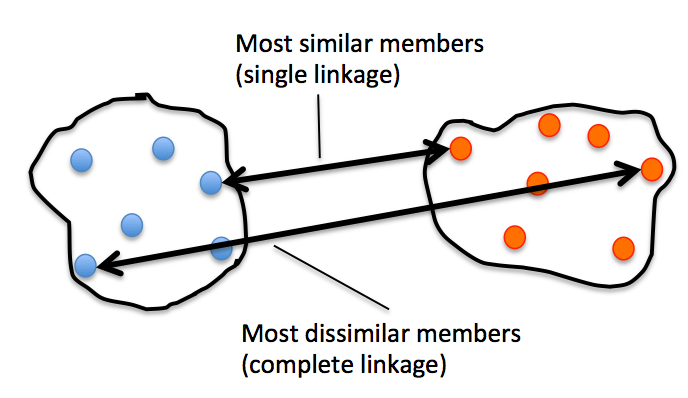

In [83]:
Image(filename='./data/11/images/11_05.png', width=500)

重点关注全连接方法的凝聚层次聚类,其迭代过程可总结如下：
1. 计算得到所有样本间的距离矩阵
2. 将每个数据点看作是一个单独的簇
3. 基于最不相似(距离最远)样本的距离,合并两个最接近的簇
4. 更新相似矩阵(样本间距离矩阵)
5. 重复步骤2到4,直到所有样本都合并到一个簇为止

我们讨论一下如何计算距离矩阵(步骤1).在此之前,需要先随机生成一些样本数据用于计算.其中行代表不同的样本(ID值从0到4),列代表样本的不同特征(X,Y,Z)

In [84]:
import pandas as pd
import numpy as np

np.random.seed(123)

variables=['X','Y','Z']

labels=['ID_0','ID_1','ID_2','ID_3','ID_4']
X=np.random.random_sample([5,3])*10

df=pd.DataFrame(X,columns=variables,index=labels)
df

,X,Y,Z
ID_0,6.964692,2.861393,2.268515
ID_1,5.513148,7.194690,4.231065
ID_2,9.807642,6.848297,4.809319
ID_3,3.921175,3.431780,7.290497
ID_4,4.385722,0.596779,3.980443


### 1.基于距离矩阵进行层次聚类

我们使用SciPy中spatial.distanct子模块下的pdist函数来计算距离矩阵,此矩阵作为层次聚类算法的输入：

在下述代码中,我们基于样本的特征X,Y,Z,使用欧几里得距离计算了样本间的两两距离.通过将pdist函数的返回值输入到squareform函数中,我们得到了一个记录成对样本间距离的对称矩阵：

In [85]:
from scipy.spatial.distance import pdist,squareform

row_dist=pd.DataFrame(squareform(
    pdist(df,metric='euclidean')
),columns=labels,index=labels)

row_dist

,ID_0,ID_1,ID_2,ID_3,ID_4
ID_0,0.000000,4.973534,5.516653,5.899885,3.835396
ID_1,4.973534,0.000000,4.347073,5.104311,6.698233
ID_2,5.516653,4.347073,0.000000,7.244262,8.316594
ID_3,5.899885,5.104311,7.244262,0.000000,4.382864
ID_4,3.835396,6.698233,8.316594,4.382864,0.000000


下面我们使用SciPy中cluster.hierarchy子模块下的linkage函数,此函数以全连接作为距离判定标准,它能够返回一个所谓的关联矩阵(linkage matrix)

In [86]:
from scipy.cluster.hierarchy import linkage
help(linkage)

Help on function linkage in module scipy.cluster.hierarchy:

linkage(y, method='single', metric='euclidean', optimal_ordering=False)
    Perform hierarchical/agglomerative clustering.
    
    The input y may be either a 1d condensed distance matrix
    or a 2d array of observation vectors.
    
    If y is a 1d condensed distance matrix,
    then y must be a :math:`\binom{n}{2}` sized
    vector where n is the number of original observations paired
    in the distance matrix. The behavior of this function is very
    similar to the MATLAB linkage function.
    
    A :math:`(n-1)` by 4 matrix ``Z`` is returned. At the
    :math:`i`-th iteration, clusters with indices ``Z[i, 0]`` and
    ``Z[i, 1]`` are combined to form cluster :math:`n + i`. A
    cluster with an index less than :math:`n` corresponds to one of
    the :math:`n` original observations. The distance between
    clusters ``Z[i, 0]`` and ``Z[i, 1]`` is given by ``Z[i, 2]``. The
    fourth value ``Z[i, 3]`` represents the n

从对函数的描述中可知：我们可以将pdist函数得到的稠密矩阵(上三角)作为输入项.或者将初始化的欧几里得距离矩阵(将矩阵参数项的值设定为euclidean)作为linkage的输入.不过我们不应使用前面提及的用squareform函数得到的距离矩阵,因为这会生成与预期不同的距离值.综合来讲,这里可能出现三种不同的情况：

1. 错误的方法：使用通过squareform函数得到的距离矩阵
from scipy.cluster.hierarchy import linkage
row_clusters=linkage(row_dist,method='complete',metric='euclidean')


2. 正确的方法：使用稠密距离矩阵
row_clusters=linkage(pdist(df,metric='euclidean'),method='complete')

3. 正确的方法：使用矩阵格式输入
row_clusters=linkage(df.values,method='complete',metric='euclidean')

In [87]:
row_clusters=linkage(pdist(df,metric='euclidean'),method='complete')

我们通过下面的方式将数据转换为pandas的DataFrame格式

In [88]:
pd.DataFrame(row_clusters,
            columns=['row label 1',
                    'row label 2',
                    'distance',
                    'no. of items in clust.'],
            index=['cluster %d'%(i+1) for i in range(row_clusters.shape[0])])

,row label 1,row label 2,distance,no. of items in clust.
cluster 1,0.0,4.0,3.835396,2.0
cluster 2,1.0,2.0,4.347073,2.0
cluster 3,3.0,5.0,5.899885,3.0
cluster 4,6.0,7.0,8.316594,5.0


采用树状图的形式对聚类结果进行可视化

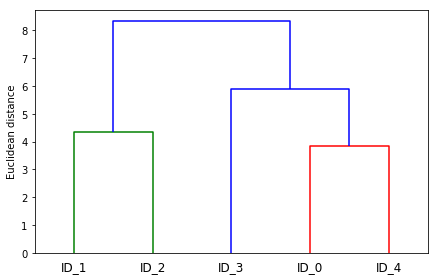

In [89]:
from scipy.cluster.hierarchy import dendrogram

row_dendr=dendrogram(row_clusters,
                    labels=labels)

plt.tight_layout()
plt.ylabel('Euclidean distance')

plt.show()

从图中可见,首先是ID_0和ID_4合并,接下来是ID_1和ID_2合并,也就是基于欧几里得距离矩阵,选择最不相似的样本进行合并

### 2.树状图与热度图的关联

1.创建一个figure对象,并通过add_axes属性来设定x轴位置,y轴位置,以及树状图的宽度和高度.此外我们沿逆时针方向将树状图旋转90度,代码如下：

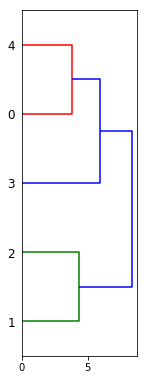

In [90]:
fig=plt.figure(figsize=(8,8))
axd=fig.add_axes([0.09,0.1,0.2,0.6])
row_dendr=dendrogram(row_clusters,orientation='right')

2.根据树状图对象中的簇类标重排初始化数据框(DataFrame)对象中的数据,它本质上是一个python字典,可通过leaves键访问得到

In [91]:
df_rowclust=df.ix[row_dendr['leaves'][::-1]]

E:\Anaconda\envs\mytensorflow\lib\site-packages\ipykernel_launcher.py:1: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated
  """Entry point for launching an IPython kernel.


3.基于重排后的数据框(DataFrame)数据,在树状图的右侧绘制热度图

In [92]:
axm=fig.add_axes([0.23,.01,0.6,0.6])
cax=axm.matshow(df_rowclust,interpolation='nearest',cmap='hot_r')

4.为了美化效果,我们删除了坐标轴标记,并将坐标轴的刻度隐藏.此外我们加入了色条,并分别在x和y轴上显示特征名和样本ID名称

In [93]:
axd.set_xticks([])
axd.set_yticks([])

for i in axd.spines.values():
    i.set_visible(False)
    
fig.colorbar(cax)

axm.set_xticklabels(['']+list(df_rowclust.columns))
axm.set_yticklabels(['']+list(df_rowclust.index))

plt.show()

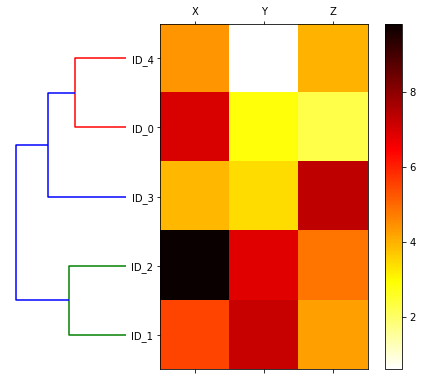

In [94]:
# plot row dendrogram
fig = plt.figure(figsize=(8, 8), facecolor='white')
axd = fig.add_axes([0.09, 0.1, 0.2, 0.6])

# note: for matplotlib < v1.5.1, please use orientation='right'
row_dendr = dendrogram(row_clusters, orientation='left')

# reorder data with respect to clustering
df_rowclust = df.iloc[row_dendr['leaves'][::-1]]

axd.set_xticks([])
axd.set_yticks([])

# remove axes spines from dendrogram
for i in axd.spines.values():
        i.set_visible(False)

# plot heatmap
axm = fig.add_axes([0.23, 0.1, 0.6, 0.6])  # x-pos, y-pos, width, height
cax = axm.matshow(df_rowclust, interpolation='nearest', cmap='hot_r')
fig.colorbar(cax)
axm.set_xticklabels([''] + list(df_rowclust.columns))
axm.set_yticklabels([''] + list(df_rowclust.index))

# plt.savefig('./figures/heatmap.png', dpi=300)
plt.show()

### 3.通过scikit-learn进行凝聚聚类

scikit-learn中已经实现了一个AgglomerativeClustering类,它允许我们选择待返回簇的数量.将参数n_cluster的值设定为2,我们可以采用与前面相同的完全连接方法,基于欧几里得距离矩阵,将样本划分为两个簇

In [95]:
from sklearn.cluster import AgglomerativeClustering

ac=AgglomerativeClustering(n_clusters=2,
                          affinity='euclidean',
                          linkage='complete')

labels=ac.fit_predict(X)

print('Cluster labels:%s'%labels)

Cluster labels:[0 1 1 0 0]


可以看出：第一,第四及第五个(ID_0,ID_3,ID_4)样本被划分至第一个簇(0),样本ID_1和ID_2被划分至第二个簇(1),与树状图得到的结果一致

## 三.使用DBSCAN划分高密度区域

基于密度空间的聚类算法(Density-based Spatial Clustering of Applications with Noise,DBSCAN).在DBSCAN中,密度被定义为指定半径ϵ范围内样本点的数量

在DBSCAN中,基于以下标准,每个样本(点)都被赋予一个特殊的标签：

- 如果在一个点周边的指定半径ϵ内,其他样本点的数量不小于指定数量(MiPts),则此样本点称为核心点(core point)
- 在指定半径ϵ内,如果一个点的邻居点少于MinPts个,但是却包含一个核心点,则此点称为边界点(border point)
- 除了核心点和边界点外的其他样本点称为噪声点(noise point)

完成对核心点,边界点和噪声点的标记后,DBSCAN算法可总结为两个简单的步骤：
1. 基于每个核心点或者一组相连的核心点(如果核心点的距离很近,则将其看作是相连的)形成一个单独的簇
2. 将每个边界点划分到其对应核心点所在的簇中

通过下图了解一下核心点,边界点和噪声点

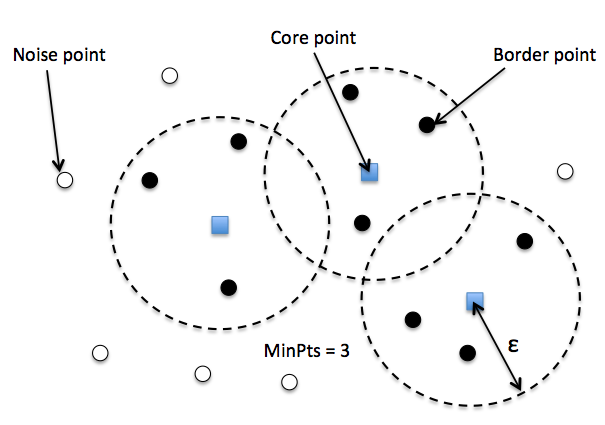

In [30]:
Image(filename='./data/11/images/11_11.png', width=500) 

与k-means算法不同,DBSCAN的簇空间不一定是球状.不同于k-means和层次聚类,由于DBSCAN可以识别并移除噪声点,因此它不一定会将所有的样本点都划分到某一个簇中

下面给出例子,我们创建一个半月形结构的数据集,以对k-means聚类,层次聚类和DBSCAN聚类进行比较

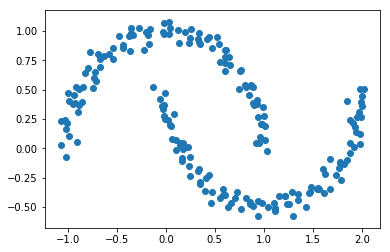

In [32]:
from sklearn.datasets import make_moons
X,y=make_moons(n_samples=200,
              noise=0.05,
              random_state=0)

plt.scatter(X[:,0],X[:,1])

plt.show()

由图像可见,数据集明显地被划分为两个半月形的分组,每个分组包含100个样本点

我们首先使用前面讨论过的k-means算法和基于全连接的层次聚类算法,看他们是否能够成功识别出半月形的簇.代码如下；

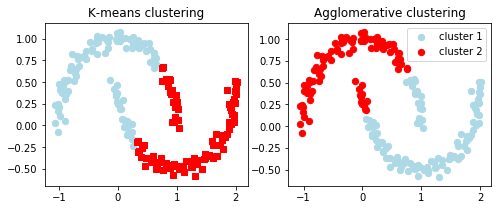

In [33]:
f,(ax1,ax2)=plt.subplots(1,2,figsize=(8,3))

km=KMeans(n_clusters=2,
         random_state=0)

y_km=km.fit_predict(X)

ax1.scatter(X[y_km==0,0],
           X[y_km==0,1],
           c='lightblue',marker='o',
           s=40,label='cluster 1')

ax1.scatter(X[y_km==1,0],
           X[y_km==1,1],
           c='red',marker='s',
           s=40,label='cluster 2')

ax1.set_title('K-means clustering')

ac=AgglomerativeClustering(n_clusters=2,affinity='euclidean',linkage='complete')

y_ac=ac.fit_predict(X)

ax2.scatter(X[y_ac==0,0],
           X[y_ac==0,1],
           c='lightblue',marker='o',
           s=40,label='cluster 1')

ax2.scatter(X[y_ac==1,0],
           X[y_ac==1,1],
           c='red',marker='o',
           s=40,label='cluster 2')

ax2.set_title('Agglomerative clustering')

plt.legend()
plt.show()

从聚类结果图像可见：k-means算法无法将两个簇分开,而这种复杂形状的数据对层次聚类来说也是一种挑战

最后,我们试一下DBSCAN算法在此数据集上的效果,看其是否能使用基于密度的方法发现两个半月形的簇：

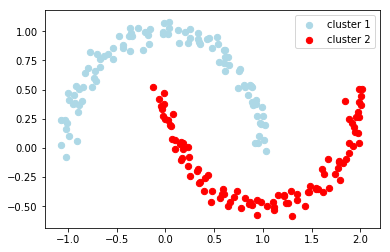

In [34]:
from sklearn.cluster import DBSCAN

db=DBSCAN(eps=0.2,min_samples=5,metric='euclidean')

y_db=db.fit_predict(X)

plt.scatter(X[y_db==0,0],
           X[y_db==0,1],
           c='lightblue',
           s=40,
           label='cluster 1')

plt.scatter(X[y_db==1,0],
           X[y_db==1,1],
           c='red',
           s=40,
           label='cluster 2')

plt.legend()
plt.show()

DBSCAN算法可以成功地对半月形数据进行划分,这也是DBSCAN的优势之一(可对任意形状的数据进行聚类)

同时,我们也应注意到DBSCAN算法的一些缺点.对于一个给定样本数量的训练数据集,随着数据集中特征数量的增加,维度灾难(curse of dimensionality)的负面影响会随之递增.在使用欧几里得距离度量时,此问题尤为突出